# Описание проекта: телекоммуникации

Оператор связи «Ниединогоразрыва.ком» хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.

___

**Описание услуг:**

Оператор предоставляет два основных типа услуг: 
1. Стационарную телефонную связь. Возможно подключение телефонного аппарата к нескольким линиям одновременно.
2. Интернет. Подключение может быть двух типов: через телефонную линию (DSL, от англ. digital subscriber line, «цифровая абонентская линия») или оптоволоконный кабель (Fiber optic).

Также доступны такие услуги:
- Интернет-безопасность: антивирус (DeviceProtection) и блокировка небезопасных сайтов (OnlineSecurity);
- Выделенная линия технической поддержки (TechSupport);
- Облачное хранилище файлов для резервного копирования данных (OnlineBackup);
- Стриминговое телевидение (StreamingTV) и каталог фильмов (StreamingMovies).

За услуги клиенты могут платить каждый месяц или заключить договор на 1–2 года. Доступны различные способы расчёта и возможность получения электронного чека.

___

**Описание данных:**

Данные состоят из файлов, полученных из разных источников:
- `contract_new.csv` — информация о договоре;
- `personal_new.csv` — персональные данные клиента;
- `internet_new.csv` — информация об интернет-услугах;
- `phone_new.csv` — информация об услугах телефонии.

Во всех файлах столбец customerID содержит код клиента.

Информация о договорах актуальна на 1 февраля 2020.

## Загрузка данных

### Импорт используемых библиотек

In [74]:
#!pip install cufflinks
#!pip install plotly
#!pip install phik

In [145]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import cufflinks as cf
import plotly.express as px
import plotly.graph_objs as go
import plotly.offline as py
from plotly.offline import iplot
from plotly.subplots import make_subplots
import plotly.figure_factory as ff
import plotly.io as pio
pio.renderers.default = "svg"

import phik
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer

from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.pipeline import Pipeline

from datetime import datetime
from IPython.core.display import display, HTML

pd.set_option('display.max_columns', None)

cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)

import warnings

warnings.filterwarnings('ignore')

display(HTML("<style>.container { width:80% !important; }</style>"))

In [76]:
RANDOM_STATE = 250923

### Чтение файлов

In [77]:
try:
    df_internet = pd.read_csv('internet_new.csv')
    df_phone = pd.read_csv('phone_new.csv')
    df_contract = pd.read_csv('contract_new.csv')
    df_personal = pd.read_csv('personal_new.csv')

except:
    df_internet = pd.read_csv('https://code.s3.yandex.net/datasets/internet_new.csv')
    df_phone = pd.read_csv('https://code.s3.yandex.net/datasets/phone_new.csv')
    df_contract = pd.read_csv('https://code.s3.yandex.net/datasets/contract_new.csv')
    df_personal = pd.read_csv('https://code.s3.yandex.net/datasets/personal_new.csv')    

Функция о выводе информации

In [78]:
def print_dataset_info(df, dataset_name):
    print(f"Информация о датасете {dataset_name}:")
    display(df.info())
    print("\nПервые 5 строк датасета:")
    display(df.head())
    print("\nСтатистическое описание данных:")
    display(df.describe())
    print("\nКоличество дубликатов:")
    display(df.duplicated().sum())

Функция просмотра значений в столбцах

In [79]:
def display_unique_values(df, column_name):
    unique_values = df[column_name].unique()
    ratios = df[column_name].value_counts(normalize=True)
    
    #print(f"Уникальные значения в столбце '{column_name}': {unique_values}")
    print("Соотношения значений:")
    print(round(ratios, 2))
    print('*'*40)
    
    #plt.figure(figsize=(9, 3))
    #sns.countplot(data=df, x=column_name, palette='deep')
    #plt.title(f'Распределение значений в столбце {column_name}')
    #plt.show()

#### Файл `internet_new`

In [80]:
#Выведем информацию
print_dataset_info(df_internet, "df_internet")

Информация о датасете df_internet:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


None


Первые 5 строк датасета:


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No



Статистическое описание данных:


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
count,5517,5517,5517,5517,5517,5517,5517,5517
unique,5517,2,2,2,2,2,2,2
top,7590-VHVEG,Fiber optic,No,No,No,No,No,No
freq,1,3096,3498,3088,3095,3473,2810,2785



Количество дубликатов:


0

In [81]:
#Посмотрим на уникальные значения
for column in df_internet.columns[1:]:
    display_unique_values(df_internet, column)

Соотношения значений:
Fiber optic    0.56
DSL            0.44
Name: InternetService, dtype: float64
****************************************
Соотношения значений:
No     0.63
Yes    0.37
Name: OnlineSecurity, dtype: float64
****************************************
Соотношения значений:
No     0.56
Yes    0.44
Name: OnlineBackup, dtype: float64
****************************************
Соотношения значений:
No     0.56
Yes    0.44
Name: DeviceProtection, dtype: float64
****************************************
Соотношения значений:
No     0.63
Yes    0.37
Name: TechSupport, dtype: float64
****************************************
Соотношения значений:
No     0.51
Yes    0.49
Name: StreamingTV, dtype: float64
****************************************
Соотношения значений:
No     0.5
Yes    0.5
Name: StreamingMovies, dtype: float64
****************************************


- Датасет содержит 5517 строк и 8 столбцов
- Пропуски отсутствуют
- Оптическое волокно является более популярным видом подключения, чем DSL
- Большинство пользователей не пользуются услугами онлайн-безопасности, резервного копирования, защиты устройств, технической поддержки
- Примерно половина пользователей пользуется стриминговыми сервисами

#### Файл `phone_new`

In [82]:
print_dataset_info(df_phone, "df_phone")

Информация о датасете df_phone:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


None


Первые 5 строк датасета:


,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes



Статистическое описание данных:


,customerID,MultipleLines
count,6361,6361
unique,6361,2
top,5575-GNVDE,No
freq,1,3390



Количество дубликатов:


0

In [83]:
for column in df_phone.columns[1:]:
    display_unique_values(df_phone, column)

Соотношения значений:
No     0.53
Yes    0.47
Name: MultipleLines, dtype: float64
****************************************


- Датасет содержит 6361 строк и 2 столбца
- Пропуски отсутствуют
- Чуть больше половины пользователей не пользуется возможностю ведения параллельных линий во время звонка

#### Файл `personal_new`

In [84]:
print_dataset_info(df_personal, "df_personal")

Информация о датасете df_personal:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


None


Первые 5 строк датасета:


,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No



Статистическое описание данных:


,SeniorCitizen
count,7043.000000
mean,0.162147
std,0.368612
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000



Количество дубликатов:


0

In [85]:
for column in df_personal.columns[1:]:
    display_unique_values(df_personal, column)

Соотношения значений:
Male      0.5
Female    0.5
Name: gender, dtype: float64
****************************************
Соотношения значений:
0    0.84
1    0.16
Name: SeniorCitizen, dtype: float64
****************************************
Соотношения значений:
No     0.52
Yes    0.48
Name: Partner, dtype: float64
****************************************
Соотношения значений:
No     0.7
Yes    0.3
Name: Dependents, dtype: float64
****************************************


- Датасет содержит 7043 строки и 5 столбцов
- Пропуски отсутствуют
- Мужчины и женщины представлены в равной степени
- Пожилых людей представлено в 6 раз меньше, чем молодых
- Клиенты в браке и не в брака представлены в равной степени
- Большинство клиентов не имеет иждевенцов

#### Файл `contract_new`

In [86]:
print_dataset_info(df_contract, "df_contract")

Информация о датасете df_contract:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


None


Первые 5 строк датасета:


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5



Статистическое описание данных:


,MonthlyCharges
count,7043.000000
mean,64.761692
std,30.090047
min,18.250000
25%,35.500000
50%,70.350000
75%,89.850000
max,118.750000



Количество дубликатов:


0

In [87]:
for column in df_contract.columns[3:-2]:
    display_unique_values(df_contract, column)

Соотношения значений:
Month-to-month    0.55
Two year          0.24
One year          0.21
Name: Type, dtype: float64
****************************************
Соотношения значений:
Yes    0.59
No     0.41
Name: PaperlessBilling, dtype: float64
****************************************
Соотношения значений:
Electronic check             0.34
Mailed check                 0.23
Bank transfer (automatic)    0.22
Credit card (automatic)      0.22
Name: PaymentMethod, dtype: float64
****************************************


- Датасет содержит 7043 строки и 5 столбцов
- Пропуски отсутствуют
- Самый популярный тип оплаты - Month-to-month
- Большинство клиентов предпочитало безналичный рассчет
- Самый популярный способ оплаты - электронный чек
- Ежемесячные траты на услуги:
  - Медиана - 70.35
  - Средняя - 64.76
- `EndDate` и `TotalCharges` имеют текстовый формат. В дальнейшем проведем нужные нам манипуляции.

##### Создание новых признаков

Проведем манипуляции с данными:

- Переведем `TotalCharges` в формат float

In [88]:
df_contract['TotalCharges'] = pd.to_numeric(df_contract['TotalCharges'], errors='coerce')

- Добавим признак статуса клиента в контексте ухода-не ухода от компании - `Churn`

In [89]:
df_contract['Churn'] = df_contract['EndDate'].apply(lambda x: x if x == 'No' else 'Yes')

#Поменяем место столбца Churn
end_date_index = df_contract.columns.get_loc('EndDate')

df_without_churn = df_contract.drop(columns=['Churn'])

df_contract = pd.concat([df_without_churn.iloc[:, :end_date_index + 1],
                        df_contract['Churn'],
                        df_without_churn.iloc[:, end_date_index + 1:]], axis=1)

- Переведем формат `BeginDate` и `EndDate` к datetime

In [90]:
df_contract['EndDate'] = df_contract['EndDate'].apply(lambda x: '2020-02-01' if x == 'No' else x)

df_contract['BeginDate'] = pd.to_datetime(df_contract['BeginDate'])
df_contract['EndDate'] = pd.to_datetime(df_contract['EndDate'])

- Добавим продолжительность пользования услугой - `DaysUsed`

In [91]:
df_contract['DaysUsed'] = (df_contract['EndDate'] - df_contract['BeginDate']).dt.days

In [92]:
df_contract.head()

,customerID,BeginDate,EndDate,Churn,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,DaysUsed
0,7590-VHVEG,2020-01-01,2020-02-01,No,Month-to-month,Yes,Electronic check,29.85,31.04,31
1,5575-GNVDE,2017-04-01,2020-02-01,No,One year,No,Mailed check,56.95,2071.84,1036
2,3668-QPYBK,2019-10-01,2020-02-01,No,Month-to-month,Yes,Mailed check,53.85,226.17,123
3,7795-CFOCW,2016-05-01,2020-02-01,No,One year,No,Bank transfer (automatic),42.30,1960.60,1371
4,9237-HQITU,2019-09-01,2020-02-01,No,Month-to-month,Yes,Electronic check,70.70,353.50,153


In [93]:
df_contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   datetime64[ns]
 3   Churn             7043 non-null   object        
 4   Type              7043 non-null   object        
 5   PaperlessBilling  7043 non-null   object        
 6   PaymentMethod     7043 non-null   object        
 7   MonthlyCharges    7043 non-null   float64       
 8   TotalCharges      7032 non-null   float64       
 9   DaysUsed          7043 non-null   int64         
dtypes: datetime64[ns](2), float64(2), int64(1), object(5)
memory usage: 550.4+ KB


Появились пропуски в столбце `TotalCharges`. Отобразим строки с ними

In [94]:
df_contract[df_contract['TotalCharges'].isnull()]

,customerID,BeginDate,EndDate,Churn,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,DaysUsed
488,4472-LVYGI,2020-02-01,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.55,NaN,0
753,3115-CZMZD,2020-02-01,2020-02-01,No,Two year,No,Mailed check,20.25,NaN,0
936,5709-LVOEQ,2020-02-01,2020-02-01,No,Two year,No,Mailed check,80.85,NaN,0
1082,4367-NUYAO,2020-02-01,2020-02-01,No,Two year,No,Mailed check,25.75,NaN,0
1340,1371-DWPAZ,2020-02-01,2020-02-01,No,Two year,No,Credit card (automatic),56.05,NaN,0
3331,7644-OMVMY,2020-02-01,2020-02-01,No,Two year,No,Mailed check,19.85,NaN,0
3826,3213-VVOLG,2020-02-01,2020-02-01,No,Two year,No,Mailed check,25.35,NaN,0
4380,2520-SGTTA,2020-02-01,2020-02-01,No,Two year,No,Mailed check,20.00,NaN,0
5218,2923-ARZLG,2020-02-01,2020-02-01,No,One year,Yes,Mailed check,19.70,NaN,0
6670,4075-WKNIU,2020-02-01,2020-02-01,No,Two year,No,Mailed check,73.35,NaN,0


Судя по дате подключения, это новые клиенты, которые еще не успели внести свой первый платеж. Можно удалить эти данные, т.к. по новым пользователям нельзя делать выводы об оттоке клиентов.

In [95]:
df_contract.shape

(7043, 10)

In [96]:
df_contract = df_contract.dropna(subset=['TotalCharges'])
df_contract = df_contract.reset_index(drop=True)

In [97]:
df_contract.shape

(7032, 10)

### Вывод

В распоряжении 4 датасета с разными размерами, но с общим признаком `customerID`. Изучили содержимое, добавили новых признаков, привели `EndDate` и `TotalCharges` к правильным форматам. В `TotalCharges` образовались пустые значения, от которых было решено избавиться.

## Предобработка данных

### Объединение датасетов

Объеденим датасеты по признаку `customerID`

In [98]:
df = df_contract.merge(df_internet, on='customerID', how='left')
df = df.merge(df_phone, on='customerID', how='left')
df = df.merge(df_personal, on='customerID', how='left')

In [99]:
df.head()

,customerID,BeginDate,EndDate,Churn,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,DaysUsed,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,2020-01-01,2020-02-01,No,Month-to-month,Yes,Electronic check,29.85,31.04,31,DSL,No,Yes,No,No,No,No,NaN,Female,0,Yes,No
1,5575-GNVDE,2017-04-01,2020-02-01,No,One year,No,Mailed check,56.95,2071.84,1036,DSL,Yes,No,Yes,No,No,No,No,Male,0,No,No
2,3668-QPYBK,2019-10-01,2020-02-01,No,Month-to-month,Yes,Mailed check,53.85,226.17,123,DSL,Yes,Yes,No,No,No,No,No,Male,0,No,No
3,7795-CFOCW,2016-05-01,2020-02-01,No,One year,No,Bank transfer (automatic),42.30,1960.60,1371,DSL,Yes,No,Yes,Yes,No,No,NaN,Male,0,No,No
4,9237-HQITU,2019-09-01,2020-02-01,No,Month-to-month,Yes,Electronic check,70.70,353.50,153,Fiber optic,No,No,No,No,No,No,No,Female,0,No,No


### Обработка пропусков

In [100]:
df.isna().sum()

customerID             0
BeginDate              0
EndDate                0
Churn                  0
Type                   0
PaperlessBilling       0
PaymentMethod          0
MonthlyCharges         0
TotalCharges           0
DaysUsed               0
InternetService     1520
OnlineSecurity      1520
OnlineBackup        1520
DeviceProtection    1520
TechSupport         1520
StreamingTV         1520
StreamingMovies     1520
MultipleLines        680
gender                 0
SeniorCitizen          0
Partner                0
Dependents             0
dtype: int64

Из-за разницы в размерах **df_phone** и **df_internet** у нас образовались пропуски. Т.к. пользователя не оказалось в этих данных, значит он не пользуется услугой, следовательно можно заменить пропуски на значение "No"

In [101]:
df = df.fillna('No')

In [102]:
df.isna().sum()

customerID          0
BeginDate           0
EndDate             0
Churn               0
Type                0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
DaysUsed            0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
MultipleLines       0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
dtype: int64

### Создание новых признаков

Введем признак количества использованных интернет-услуг - `TotalServicesUsed`

In [103]:
df['TotalServicesUsed'] = df[['OnlineSecurity',
                                  'OnlineBackup',
                                  'DeviceProtection',
                                  'TechSupport',
                                  'StreamingTV',
                                  'StreamingMovies',
                                  'MultipleLines']].apply(lambda row: row.str.lower() == 'yes').sum(axis=1)

Введем признак пользования интернетом и телефоном одновременно - `InternetAndPhoneBundle`

In [104]:
df['InternetAndPhoneBundle'] = (
    ((df['InternetService'] == 'DSL') | (df['InternetService'] == 'Fiber optic')) 
    & (df['MultipleLines'] == 'Yes')).astype(int)

Введем признак пользования всеми интернет-услугами - `InternetAll`

In [105]:
df['InternetAll'] = (df['TotalServicesUsed'] == 7).astype(int)

Введем ABC-сегментацию, основанную на ежемесячных платежах - `Segment`

In [106]:
# Возьмем константы из закона Паретто
a_segment = df['MonthlyCharges'].quantile(.8)
b_segment = df['MonthlyCharges'].quantile(.16)

df['Segment'] = 'C' 

# Обновим значения для категории A
df.loc[
    df['MonthlyCharges'] > a_segment, 'Segment'] = 'A'

# Обновим значения для категории B
df.loc[
    (b_segment < df['MonthlyCharges']) &
    (df['MonthlyCharges'] <= a_segment),
    'Segment'] = 'B'

In [107]:
df.head()

,customerID,BeginDate,EndDate,Churn,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,DaysUsed,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,gender,SeniorCitizen,Partner,Dependents,TotalServicesUsed,InternetAndPhoneBundle,InternetAll,Segment
0,7590-VHVEG,2020-01-01,2020-02-01,No,Month-to-month,Yes,Electronic check,29.85,31.04,31,DSL,No,Yes,No,No,No,No,No,Female,0,Yes,No,1,0,0,B
1,5575-GNVDE,2017-04-01,2020-02-01,No,One year,No,Mailed check,56.95,2071.84,1036,DSL,Yes,No,Yes,No,No,No,No,Male,0,No,No,2,0,0,B
2,3668-QPYBK,2019-10-01,2020-02-01,No,Month-to-month,Yes,Mailed check,53.85,226.17,123,DSL,Yes,Yes,No,No,No,No,No,Male,0,No,No,2,0,0,B
3,7795-CFOCW,2016-05-01,2020-02-01,No,One year,No,Bank transfer (automatic),42.30,1960.60,1371,DSL,Yes,No,Yes,Yes,No,No,No,Male,0,No,No,3,0,0,B
4,9237-HQITU,2019-09-01,2020-02-01,No,Month-to-month,Yes,Electronic check,70.70,353.50,153,Fiber optic,No,No,No,No,No,No,No,Female,0,No,No,0,0,0,B


Поменяем местами столбцы для удобства работы

In [108]:
end_date_index = df.columns.get_loc('EndDate')

df_without_col = df.drop(columns=['MonthlyCharges', 'TotalCharges', 'DaysUsed'])

df = pd.concat([df_without_col.iloc[:, :end_date_index + 1],
                        df[['MonthlyCharges', 'TotalCharges', 'DaysUsed']],
                        df_without_col.iloc[:, end_date_index + 1:]], axis=1)

Переведем несколько признаков к типу object для корректного отображения графиков

In [109]:
df['SeniorCitizen'] = df['SeniorCitizen'].astype(str)
df['TotalServicesUsed'] = df['SeniorCitizen'].astype(str)
df['InternetAndPhoneBundle'] = df['InternetAndPhoneBundle'].astype(str)
df['InternetAll'] = df['InternetAll'].astype(str)

In [110]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7031
Data columns (total 26 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   customerID              7032 non-null   object        
 1   BeginDate               7032 non-null   datetime64[ns]
 2   EndDate                 7032 non-null   datetime64[ns]
 3   MonthlyCharges          7032 non-null   float64       
 4   TotalCharges            7032 non-null   float64       
 5   DaysUsed                7032 non-null   int64         
 6   Churn                   7032 non-null   object        
 7   Type                    7032 non-null   object        
 8   PaperlessBilling        7032 non-null   object        
 9   PaymentMethod           7032 non-null   object        
 10  InternetService         7032 non-null   object        
 11  OnlineSecurity          7032 non-null   object        
 12  OnlineBackup            7032 non-null   object  

### Построение графиков

Выделим в список категорийные признаки

In [111]:
cat_cols = df.select_dtypes(include=['object']).columns.tolist()[1:]
cat_cols

['Churn',
 'Type',
 'PaperlessBilling',
 'PaymentMethod',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'MultipleLines',
 'gender',
 'SeniorCitizen',
 'Partner',
 'Dependents',
 'TotalServicesUsed',
 'InternetAndPhoneBundle',
 'InternetAll',
 'Segment']

Построим графики

In [146]:
fig = px.histogram(df, x="Churn", color="Churn", width=400, height=500)
fig.show()

In [113]:
#def show_hist(column):
#    fig = px.histogram(df, x=column, color="Churn", width=300, height=300)
#    fig.show()

# Применяем функцию к каждому столбцу из cat_cols
#for col in cat_cols:
#    show_hist(col)

In [114]:
def show_hist(column):
    # Создаем DataFrame с процентами
    percentages = round(
        (df.groupby([column, 'Churn']).size() / df.groupby([column]).size())
        .reset_index(name='Percentage'), 2)

    # Строим гистограмму с процентами
    fig = px.bar(
        percentages,
        x=column,
        y='Percentage',
        color='Churn',
        barmode='group',
        text='Percentage',
        labels={'Percentage': 'Percentage (%)'},
        width=800,
        height=400
    )
    
    fig.update_traces(textfont_size=20)

    fig.update_layout(
        title=column + " distribution by Churn",
        plot_bgcolor="rgb(243,243,243)",
        paper_bgcolor="rgb(243,243,243)"
    )

    fig.show()

In [115]:
for col in cat_cols:
    if col != 'Churn':  # Исключаем столбец 'Churn'
        show_hist(col)

Построим гистограммы по числовым признакам

In [116]:
df[['DaysUsed', 'TotalCharges', 'MonthlyCharges']].iplot(kind='histogram', subplots=True, bins=50)

- Соотношение ушедших клиентов к оставишимся - 1 к 6
- Клиенты с ежемесячными платежами самые лояльные. 
- Те, кто заключал договор в электронном виде, отваливаются чаще
- Клиенты, оформляющие платеж по почте - самые лояльные. Больше всего отвала у тех пользователей, у которых подключена автоматическая оплата.
- Клиенты, к которым подключен интернет способом "Fiber optic" отваливаются чаще
- Пользователи, пользующиеся дополнительными услугами примерно в 2 раза чаще расторгают контракт
- Половая принадлежность клиентов никакой роли не играет
- С клиентами, которые подходят под категорию "SeniorCitizen", чаще растограется договор
- Клиенты, имеющие партнера или (и) иждивенцов, чаще отваливаются
- Больше четверти от сегмента клиентов, ежемесячный доход от которых составляет 80+%, склонны к отвалу. Это больше, чем категории B и C вместе взятые.

### Корреляции

Удалим ненужные для дальнейших исследований столбцы

In [117]:
df = df.drop(['customerID', 'BeginDate', 'EndDate'], axis=1)

interval columns not set, guessing: ['MonthlyCharges', 'TotalCharges', 'DaysUsed']


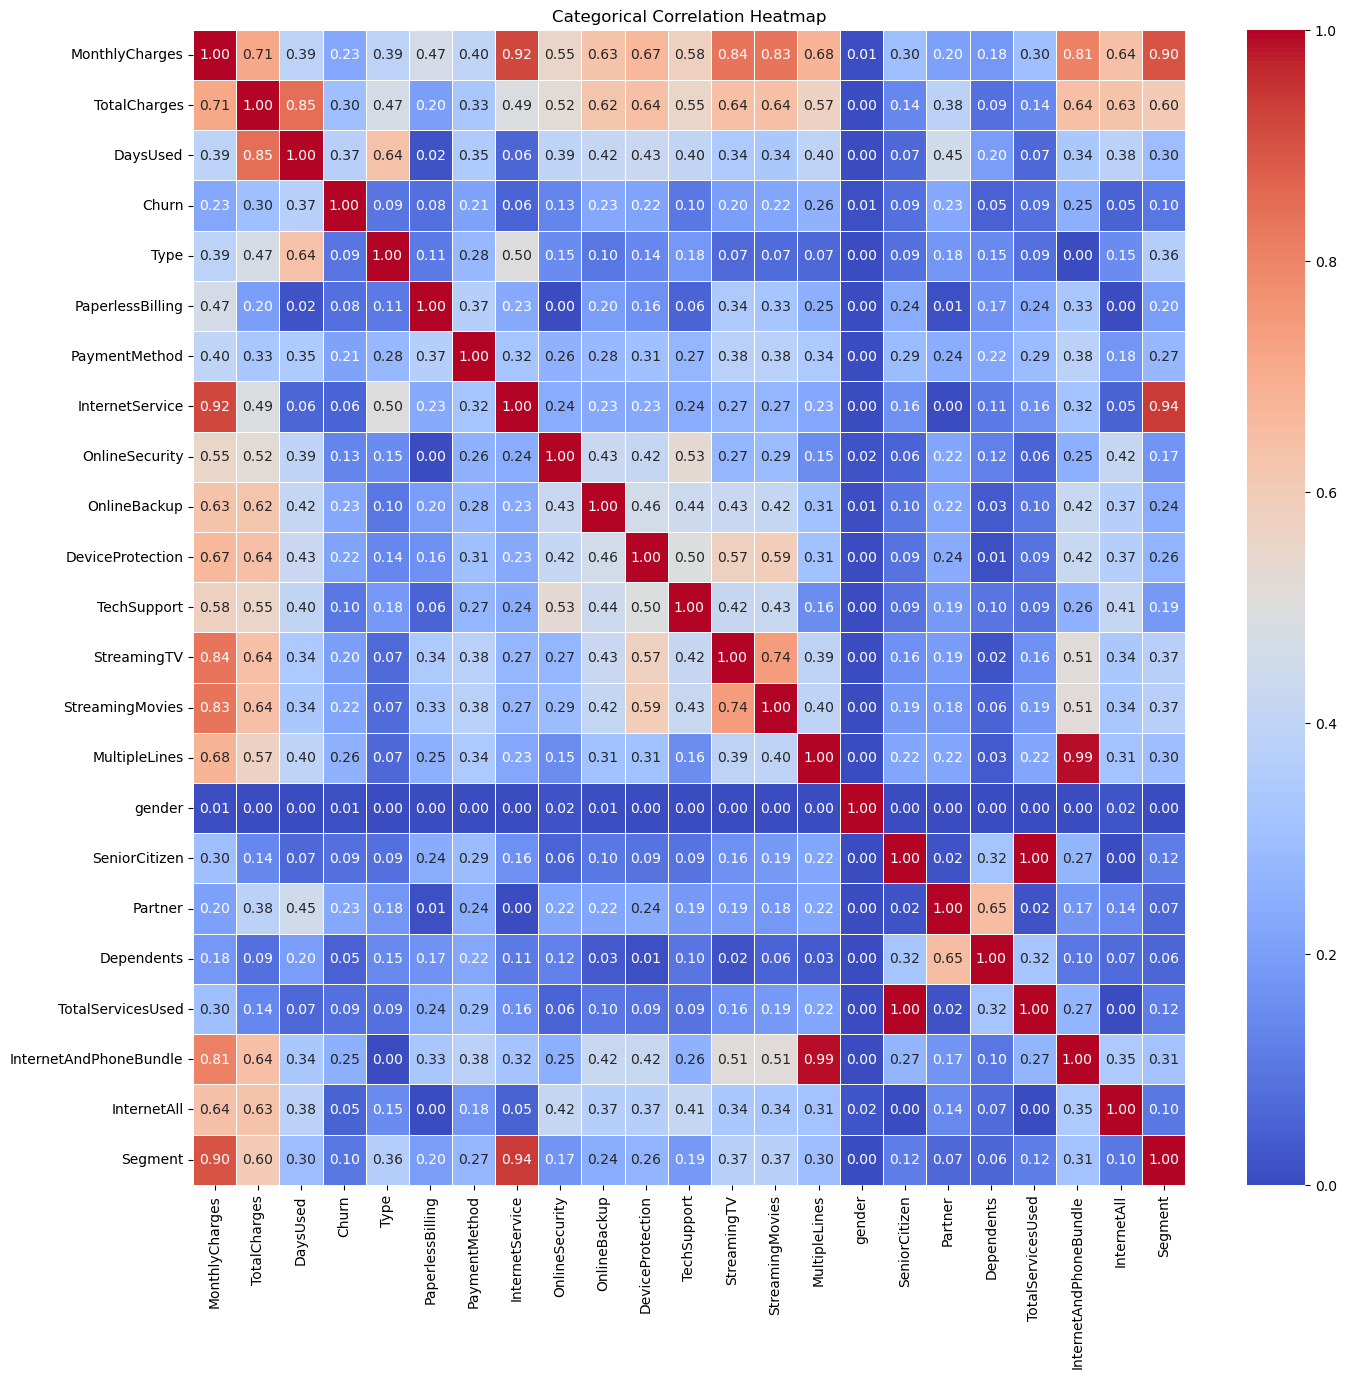

In [118]:
#corr_df = df[cat_cols].phik_matrix()

# Рассчитываем корреляцию с использованием phik
corr_df = df.phik_matrix()

# Строим тепловую карту
plt.figure(figsize=(16, 15))
sns.heatmap(corr_df, annot=True, cmap="coolwarm", fmt=".2f", linewidths=.5)
plt.title("Categorical Correlation Heatmap")
plt.show()

- Наблюдаем высокую корреляцию между `TotalCharges` и `DaysUsed`. Оно и логично, оба признака показывают суммарные значения платежей и время пользования услугами компании.
- `StreamingTV` и `StreamingMovies` имеют между собой высокую корреляцию. Также их корреляции с другими признаками очень похожи (максимальная разница - 0,04).
- `MonthlyCharges`, `InternetService` и `Segment` имеют между собой высокую корреляцию. Можно предположить, что данная услуга очень дорого стоит
- `MultipleLines` и `InternetAndPhoneBundle` имеют почти полную корреляцию.
- `SeniorCitizen` и `TotalServicesUsed` имеют полную корреляцию.

### Вывод

- Объединили датасеты в один
- Заполнили образовавшиеся пустоты
- Удалили нерелевантные данные
- Создали новые признаки
- Проверили корреляцию признаков
- Удалили несколько признаков, которые имели высокую корреляцию с другими признаками

## Деление на выборки

In [119]:
features = df.drop(['Churn'], axis=1)
target = df['Churn']

Кодируем целевой признак

In [120]:
label_encoder = LabelEncoder()
target = label_encoder.fit_transform(target)
target

array([0, 0, 0, ..., 0, 0, 0])

In [121]:
features_train, features_test, target_train, target_test = train_test_split(
    features,
    target,
    test_size=0.25,
    stratify=target,
    random_state=RANDOM_STATE)

## Масштабирование и преобразование категориальных признаков

In [122]:
cat_features = features_train.select_dtypes(include='object').columns.to_list()

In [123]:
num_features = features_train.select_dtypes(exclude='object').columns.to_list()

In [124]:
preprocessor = ColumnTransformer(
    transformers=[
        ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore'), cat_features),
        ('scaler', StandardScaler(), num_features)
    ],
    remainder='passthrough'
)

## Обучение моделей

Создадим датасет, в который будут собираться результаты обучения моделей

In [125]:
best_models = pd.DataFrame(columns=['model', 'ROC-AUC'])

### CatBoostClassifier

In [126]:
pipeline_catboost = Pipeline([
    ('preprocessor', preprocessor),
    ("catboost", CatBoostClassifier(loss_function="Logloss", verbose=25))
])

param_grid = {
    'catboost__iterations': [100, 200, 301],
    'catboost__learning_rate': [0.01, 0.1, 0.2],
    'catboost__depth': [6, 8, 10]
}

grid_catboost = GridSearchCV(estimator=pipeline_catboost,
                             param_grid=param_grid,
                             scoring='roc_auc',
                             cv=5,
                             n_jobs=-1)

grid_catboost.fit(features_train, target_train)

roc_auc_catboost = grid_catboost.best_score_

print("Лучшие параметры:", grid_catboost.best_params_)
print("ROC-AUC:", roc_auc_catboost)

0:	learn: 0.5631184	total: 2.89ms	remaining: 867ms
25:	learn: 0.2918500	total: 83.5ms	remaining: 883ms
50:	learn: 0.2520701	total: 166ms	remaining: 812ms
75:	learn: 0.2075024	total: 259ms	remaining: 767ms
100:	learn: 0.1767336	total: 357ms	remaining: 707ms
125:	learn: 0.1565656	total: 494ms	remaining: 686ms
150:	learn: 0.1412578	total: 652ms	remaining: 647ms
175:	learn: 0.1267128	total: 783ms	remaining: 556ms
200:	learn: 0.1160909	total: 898ms	remaining: 447ms
225:	learn: 0.1061725	total: 1.04s	remaining: 346ms
250:	learn: 0.0975179	total: 1.13s	remaining: 226ms
275:	learn: 0.0889954	total: 1.22s	remaining: 110ms
300:	learn: 0.0817166	total: 1.29s	remaining: 0us
Лучшие параметры: {'catboost__depth': 6, 'catboost__iterations': 301, 'catboost__learning_rate': 0.2}
ROC-AUC: 0.9038801346405533


In [127]:
best_models.loc[0] = ['CatBoostClassifier', roc_auc_catboost]

### XGBClassifier

In [128]:
pipeline_xgb = Pipeline(
    [
        ('preprocessor', preprocessor),
        ("xgb", XGBClassifier())
    ]
)

param_grid = {
    'xgb__n_estimators': [50, 100],
    'xgb__max_depth': [5, 10],
    'xgb__learning_rate': [0.1, 0.2],
    'xgb__subsample': [0.8, 1.0]
}

grid_xgb = GridSearchCV(estimator=pipeline_xgb,
                        param_grid=param_grid,
                        scoring='roc_auc',
                        cv=5,
                        n_jobs=-1)

grid_xgb.fit(features_train, target_train)

roc_auc_xgb = grid_xgb.best_score_

print("Лучшие параметры:", grid_xgb.best_params_)
print("ROC-AUC:", roc_auc_xgb)

Лучшие параметры: {'xgb__learning_rate': 0.2, 'xgb__max_depth': 5, 'xgb__n_estimators': 100, 'xgb__subsample': 1.0}
ROC-AUC: 0.8773919192512911


In [129]:
best_models.loc[1] = ['XGBClassifier', roc_auc_xgb]

### RandomForestClassifier

In [130]:
pipeline_rf = Pipeline([
    ('preprocessor', preprocessor),
    ('rf', RandomForestClassifier())
])

param_grid = {
    'rf__n_estimators': [50, 100],
    'rf__max_depth': [5, 10],
    'rf__min_samples_split': [2, 5],
    'rf__min_samples_leaf': [1, 2]
}

grid_rf = GridSearchCV(estimator=pipeline_rf,
                       param_grid=param_grid,
                       scoring='roc_auc',
                       cv=5,
                       n_jobs=-1)

grid_rf.fit(features_train, target_train)

roc_auc_rf = grid_rf.best_score_

print("Лучшие параметры:", grid_rf.best_params_)
print("ROC-AUC:", roc_auc_rf)

Лучшие параметры: {'rf__max_depth': 10, 'rf__min_samples_leaf': 1, 'rf__min_samples_split': 2, 'rf__n_estimators': 100}
ROC-AUC: 0.8207163593887067


In [131]:
best_models.loc[2] = ['RandomForestClassifier', roc_auc_rf]

### LogisticRegression

In [132]:
pipeline_logreg = Pipeline([
    ('preprocessor', preprocessor),
    ('logreg', LogisticRegression())
])

param_grid_logreg = {
    'logreg__C': [0.1, 1.0, 10.0],
    'logreg__penalty': ['l2'],
    'logreg__max_iter': [100, 200, 300],
}

grid_logreg = GridSearchCV(estimator=pipeline_logreg,
                           param_grid=param_grid_logreg,
                           scoring='roc_auc',
                           cv=5,
                           n_jobs=-1)

grid_logreg.fit(features_train, target_train)

roc_auc_logreg = grid_logreg.best_score_

print("Лучшие параметры:", grid_logreg.best_params_)
print("ROC-AUC:", roc_auc_logreg)

Лучшие параметры: {'logreg__C': 10.0, 'logreg__max_iter': 100, 'logreg__penalty': 'l2'}
ROC-AUC: 0.7661243248454533


In [133]:
best_models.loc[3] = ['LogisticRegression', roc_auc_logreg]

In [134]:
best_models

,model,ROC-AUC
0,CatBoostClassifier,0.903880
1,XGBClassifier,0.877392
2,RandomForestClassifier,0.820716
3,LogisticRegression,0.766124


Лучшую метрику **ROC-AUC** показала модель `CatBoostClassifier` - 0.903880

## Тестирование

Проверим нашу модель на тестовой выборке

In [135]:
#roc_auc_score(target_test, grid_catboost.predict_proba(features_test)[:, 1])

In [136]:
test_catboost = roc_auc_score(target_test, grid_catboost.predict_proba(features_test)[:, 1])
test_catboost

0.9071709679396801

Тестирование прошло успешно. Узнаем метрику **accuracy**, **precision**, **recall** данной модели

In [137]:
predicted_labels = grid_catboost.predict(features_test)

accuracy_catboost = accuracy_score(target_test, predicted_labels)
precision_catboost = precision_score(target_test, predicted_labels)
recall_catboost = recall_score(target_test, predicted_labels)

In [138]:
print(accuracy_catboost)
print(precision_catboost)
print(recall_catboost)

0.9106939704209329
0.8597560975609756
0.5127272727272727


## Важность признаков

Вынесем важность признаков в переменную

In [139]:
feature_importances = grid_catboost.best_estimator_._final_estimator.feature_importances_

Создадим список признаков

In [140]:
features_transformed = preprocessor.fit_transform(features_train)

ohe_feature_names = preprocessor.named_transformers_['ohe'].get_feature_names_out(input_features=cat_features)
num_feature_names = num_features

feature_names = np.concatenate([ohe_feature_names, num_feature_names])

Создадим общий датасет

In [141]:
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

Построим график для наглядности

In [142]:
importance_df = importance_df.sort_values(by='Importance', ascending=False)

bar_trace = go.Bar(
    x=importance_df['Feature'],
    y=importance_df['Importance'],
    marker_color='blue'  # You can customize the color if needed
)

layout = go.Layout(
    title='Важность признаков',
    xaxis=dict(title='Feature'),
    yaxis=dict(title='Importance'),
    plot_bgcolor="rgb(243,243,243)",
    paper_bgcolor="rgb(243,243,243)"
)

fig = go.Figure(data=[bar_trace], layout=layout)

fig.show()

Признак `DaysUsed` оказался самым важным. Следующий по важности - `MonthlyCharges`.

## Вывод

В распоряжении имелось 4 датасета с информацией о клиентах и подключенных ими услугах:

 - **df_internet** 
 - **df_phone**
 - **df_contract**
 - **df_personal**
 
___

После первичного изучения данных было приянто решение объеденить датасеты по признаку `customerID`. Т.к. датафреймы имели разное количество строк, в новом датасете, **df**, после мерджа образовались пустоты, которые мы успешно заполнили.

Далее было принято решение занятся созданием новых фичей на основе уже имеющихся.

После манипуляций с данными построили графики, на которых смогли оценить долю отвалившихся пользователей в каждом признаке и оценить корреляцию столбцов.

Перед началом обучения моделей были удалены несколько признаков (`MultipleLines`, `TotalCharges`, `customerID`, `BeginDate`, `EndDate`) чтобы уменьшить мультикоррелиарность данных.

___

Разделили датасет на тренировочную и тестовую выборки в соотношении 4:1. Провели преобразование категорий с помощью `OneHotEncoder`, масштабировали числовые признаки посредством `StandardScaler`.

___

Выбрали 4 модели для обучения на тренировочной выборке:

 - `CatBoostClassifier`
 - `XGBClassifier`
 - `RandomForestClassifier`
 - `LogisticRegression`
 
Наилучшую **ROC_AUC** метрику показала модель `CatBoostClassifier` - **0.903**. Гиперпараметры лучшей модели:

- depth: 6
- iterations: 301
- learning_rate: 0.2

Далее проверили нашу модель на тестовой выборке:

- **ROC_AUC - 0.909**
- **Accuracy - 0.916**

Значение ROC_AUC удовлетворяет нашему условию - быть больше 0.85.

___

Проверили важность признаков при обучении нашей модели. Самым важным оказался `DaysUsed`, его значение равно ~ 42. Следующий по важности - `MonthlyCharges`, его значение ~ 11

## Отчет по работе

Работа велась по 4-м датасетам (ссылки прилагаются):

- 'https://code.s3.yandex.net/datasets/internet_new.csv'
- 'https://code.s3.yandex.net/datasets/phone_new.csv'
- 'https://code.s3.yandex.net/datasets/contract_new.csv'
- 'https://code.s3.yandex.net/datasets/personal_new.csv'

После изучения данных мерджим датафреймы и приступаем к предобработке

___

Т.к. размеры датасетов неоднородны, заполняем образовавшиеся пустоты значением "No".

Значение "No" в `EndDate` меняем на актуальную дату выгрузки данных.

Меняем тип данных у `TotalCharges` на object (в столбце образуются пропуски, удаляем их), `EndDate` и `BeginDate` - на datetime.

Создаем новые признаки:

- `Churn` основан на признаке `EndDate`: если юзер расторг договор - значение "Yes", если нет - "No"
- `DaysUsed` основан на признаках `EndDate`, `BeginDate`: показывает количество дней пользования услугами компании
- `TotalServicesUsed` основан на признаках `OnlineSecurity`, `OnlineBackup`, `DeviceProtection`, `TechSupport`, `StreamingTV`, `StreamingMovies`, `MultipleLines`: сумма подключенных услуг клиенту
- `InternetAndPhoneBundle` основан на `InternetService` и `MultipleLines`: признак пользования услугами интернета и телефона одновременно
- `InternetAll` основан на `TotalServicesUsed`: признак того, подключены ли клиенту все интернет услуги.
- `Segment`: проводим сегментацию пользователей по `MonthlyCharges` согласно правилу Паретто на группы "A", "B" и "C". 

___

Для дальнейшего обучения было принято решение избавится от признаков `customerID`, `BeginDate`, `EndDate`.

Кодируем целевой признак `Churn` с помощью **LabelEncoding**.

Набор других признаков для обучения:

- `MonthlyCharges`
- `TotalCharges`
- `DaysUsed`
- `Type`
- `PaperlessBilling`
- `PaymentMethod`
- `InternetService`
- `OnlineSecurity`
- `OnlineBackup`
- `DeviceProtection`
- `TechSupport`
- `StreamingTV`
- `StreamingMovies`
- `MultipleLines`
- `gender`
- `SeniorCitizen`
- `Partner`
- `Dependents`
- `TotalServicesUsed`
- `InternetAndPhoneBundle`
- `InternetAll`
- `Segment`

Делим фичи на тренировочную и тестовую выборки, используя стратификацию и параметры *test_size=0.25* и *random_state=250923*.

Используем **OneHotEncoder** для кодирования категориальных признаков, **StandardScaler** - для числовых.

___

Итоговая модель, показавшая наилучшую ROC-AUC метрку - `CatBoostClassifier` с гиперпараметрами:

- **depth**: 6
- **iterations**: 301
- **learning_rate**: 0.2

___

Делая проект, я придерживался поставленному мной ранее плану

___

Проблема была в обучении модели после кодировки. Глобально, я пытался скормить модели признак `Churn` с текстовыми значениями. LabelEncoding помог исправить эту ситуацию. Ключевым этапом считаю кодировку данных, т.к. этот этап занял у меня немало времени.

___

*test_size=0.25* и *random_state=250923*.